In [22]:
# 폴더 구조
# YOLOV8 - CNN - CNN_Test.ipynb
#        ㄴ Data - CNN -  office      - [images]
#                      ㄴ non_office  - [images]

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing import image
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import shutil

In [4]:
# 이미지 재배치를 위한 경로 설정
office_dir = "../Data/All_Image/All_Image/office/"
smart_dir = "../Data/All_Image/All_Image/smart/"
webcam_dir = "../Data/All_Image/All_Image/webcam/"
office_save_dir = "../Data/CNN/office/"
non_office_save_dir = "../Data/CNN/non_office/"

In [5]:
def copy_and_rename_images(office_dir, office_save_dir):
    # 저장 폴더 확인 및 생성
    if not os.path.exists(office_save_dir):
        os.makedirs(office_save_dir)

    # counter : 이미지 번호
    # counter = 해당폴더에 있는 이미지 개수 +1
    counter = len([name for name in os.listdir(office_save_dir) if os.path.isfile(os.path.join(office_save_dir, name))]) + 1

    # 기존 폴더에서 CNN 데이터 폴더로 이미지 복사하기, 이름 재설정
    # office_01.jpg
    # non_office_01.jpg    
    for root, dirs, files in os.walk(office_dir):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                src_path = os.path.join(root, file)

                new_file_name = f"office_{str(counter).zfill(2)}.jpg"
                target_path = os.path.join(office_save_dir, new_file_name)

                shutil.copy2(src_path, target_path)
                
                counter += 1

In [10]:
# 폴더 설정
dir = "../Data/All_Image/All_Image/office/"
# dir = "../Data/All_Image/All_Image/smart/"
# dir = "../Data/All_Image/All_Image/webcam/"
save_dir = "../Data/CNN/office/"
# save_dir = "../Data/CNN/non_office/"

# copy_and_rename_images 실행
copy_and_rename_images(dir, save_dir)

In [18]:
office_dir_cnn = "../Data/CNN/office/"
non_office_dir_cnn = "../Data/CNN/non_office/"

# 변수 시드 고정
seed = 123
tf.random.set_seed(seed)

# 이미지 호출
office_images = [office_dir_cnn + f for f in os.listdir(office_dir_cnn)]
non_office_images = [non_office_dir_cnn + f for f in os.listdir(non_office_dir_cnn)]

# 이미지와 라벨 각각 결합
images = office_images + non_office_images
labels = ['office']*len(office_images) + ['non_office']*len(non_office_images)

# ratio 결정
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=1-train_ratio, stratify=labels, random_state=seed)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=test_ratio/(test_ratio + val_ratio), stratify=test_labels, random_state=seed)

# 이미지 전처리
def process_path(file_path):
    # Load the raw data from the file
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img /= 255.0
    return img

# 라벨 변경 ( label -> 0, 1 )
def process_label(label):
    return label == "office"

# 데이터셋 생성 (이미지 + 라벨)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# 데이터셋에 이미지 전처리 적용
train_dataset = train_dataset.map(lambda x, y: (process_path(x), process_label(y)))
val_dataset = val_dataset.map(lambda x, y: (process_path(x), process_label(y)))
test_dataset = test_dataset.map(lambda x, y: (process_path(x), process_label(y)))

# Batch datasets
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [19]:
# 모바일넷v2 로드
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

# 모바일넷v2 모델을 그대로 사용
base_model.trainable = False

# 층 추가
model = Sequential([
  base_model,
  Dense(256, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 트레이닝
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# loss, accuray 출력
loss, accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/10
90/90 [==============================] - 5s 31ms/step - loss: 0.1248 - accuracy: 0.9489 - val_loss: 0.0366 - val_accuracy: 0.9903
Epoch 2/10
90/90 [==============================] - 2s 24ms/step - loss: 0.0362 - accuracy: 0.9857 - val_loss: 0.0365 - val_accuracy: 0.9878
Epoch 3/10
90/90 [==============================] - 2s 24ms/step - loss: 0.0254 - accuracy: 0.9927 - val_loss: 0.0268 - val_accuracy: 0.9927
Epoch 4/10
90/90 [==============================] - 2s 24ms/step - loss: 0.0154 - accuracy: 0.9937 - val_loss: 0.0318 - val_accuracy: 0.9903
Epoch 5/10
90/90 [==============================] - 2s 24ms/step - loss: 0.0119 - accuracy: 0.9951 - val_loss: 0.0230 - val_accuracy: 0.9903
Epoch 6/10
90/90 [==============================] - 2s 23ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.0134 - val_accuracy: 0.9951
Epoch 7/10
90/90 [==============================] - 2s 24ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0149 - val_accuracy: 0.9927
Epoch 8/10
90

26/26 [==============================] - 1s 21ms/step


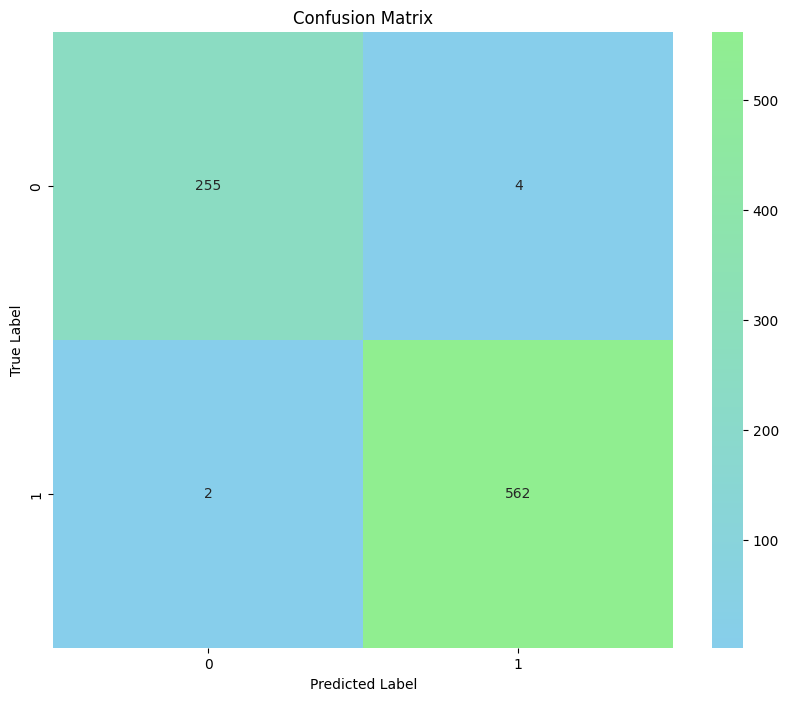

In [20]:
# 테스트 데이터셋 predict
test_pred = model.predict(test_dataset)
test_pred_classes = np.round(test_pred) # round to get binary classification result

# Get the true labels of the test data
test_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred_classes) 

# Define a custom colormap
colors = ["skyblue", "lightgreen"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=cmap)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(test_true, test_pred_classes, target_names=['non_office', 'office'])

print(report)

              precision    recall  f1-score   support

  non_office       0.99      0.98      0.99       259
      office       0.99      1.00      0.99       564

    accuracy                           0.99       823
   macro avg       0.99      0.99      0.99       823
weighted avg       0.99      0.99      0.99       823



In [26]:
# 단일 이미지 전처리 및 표현
def show_image_and_predictclass(random_image_path):
    img = image.load_img(random_image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize to [0,1]
    img_array = img_array / 255.0  

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = 'office' if np.round(prediction) else 'non_office'

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class}")
    plt.show()

1/1 [==============================] - 0s 22ms/step


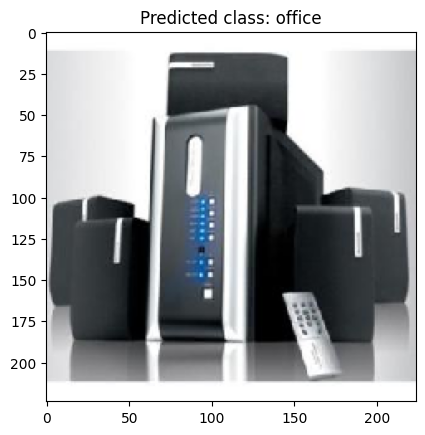

In [27]:
# 오피스 랜덤 이미지 결과값 테스트
office_images = os.listdir(office_dir_cnn)
random_image_path = os.path.join(office_dir_cnn, random.choice(office_images))
show_image_and_predictclass(random_image_path=random_image_path)

1/1 [==============================] - 0s 25ms/step


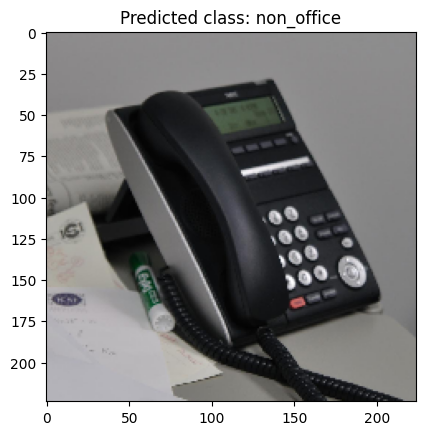

In [28]:
dir = 'non_office_dir_cnn'
images = os.listdir(dir)
random_image_path = os.path.join(dir, random.choice(images))

start_time = time.time()
show_image_and_predictclass(random_image_path=random_image_path)

end_time = time.time()
execution_time = end_time - start_time

print("실행 시간:", execution_time)